In [7]:
def get_plateid_from_image(img, expected_digits):
    from ultralytics import YOLO
    import cv2
    import easyocr

    model_path = 'models/detect-plateid.pt'
    model = YOLO(model_path)

    results = model(img, conf = 0.014, iou = 0.7)

    if results[0].boxes:
        # Assuming len(results)==1
        print(results)
        box = results[0].boxes.xyxy.numpy().astype(int)[0]
        crop = img.crop((box[0], box[1], box[2], box[3]))
        # img[box[1]:box[3], box[0]:box[2]]
        rotatedCrop = np.rot90(crop, k=-1)

        # Initialize the EasyOCR reader
        reader = easyocr.Reader(['en'])

        # Perform OCR (only look for NUMERICAL digits)
        ocr_results = reader.readtext(rotatedCrop)
        numerical_characters = ''.join([entry[1] for entry in ocr_results if entry[1].isdigit()])

        # The desired output should have 
        if len(numerical_characters)==expected_digits:
            return numerical_characters
        else:
            return 'Non-readable'
            console.log('Unable to extract plate_id')
    else: 
        return 'Non-detected'
    
def get_positions(circles, num_rows, num_cols):
    import numpy as np
    from sklearn.cluster import KMeans

    # Location algorithm for desired pocillo    
    x_kmeans = KMeans(n_clusters=num_cols, n_init=num_cols-1).fit(circles[:,0].reshape(-1, 1))
    x_labels, x_centers = x_kmeans.labels_, x_kmeans.cluster_centers_.squeeze()
    
    x_new_labels = np.zeros_like(x_labels)
    for i in range(len(x_centers)):
        x_new_labels[x_labels == i] = np.where(np.argsort(x_centers) == i)[0][0] 

    y_kmeans = KMeans(n_clusters=num_rows, n_init=num_rows-1).fit(circles[:,1].reshape(-1, 1))
    y_labels, y_centers = y_kmeans.labels_, y_kmeans.cluster_centers_.squeeze()
    
    y_new_labels = np.zeros_like(y_labels)
    for i in range(len(y_centers)):
        y_new_labels[y_labels == i] = np.where(np.argsort(y_centers) == i)[0][0]
        
    # Output is a dataframe where each row corresponds to a different circle.
    # We give coordinates of center, value of radius, row number and column number (in the grid)
    
    return np.column_stack((circles, y_new_labels+1,  x_new_labels+1))

def get_path_dict(results):
    # Get dictiionary with count of pathogens on a YOLO result

    names = results[0].names
    number_colonies = np.zeros((len(names)), dtype = int)
    
    for i in range(0, len(results[0])):
        box = results[0].boxes[i]
        class_id = int(box.cls[0].item())
        number_colonies[class_id] = number_colonies[class_id] + 1

    counting = {}
    for i in range(0, len(names)):
        bacteria_name = names.get(i)
        counting[bacteria_name] = int(number_colonies[i])

    return counting
    
def get_row_sample_info(plate_id, muestras_df, experiment_folder_path):
    fechaExperimento = experiment_folder_path.split("/")[-1][:10]

    try:
        if any(muestras_df['Plate_id'] == plate_id):
            return_dict = {'UpperRow': [fechaExperimento] + list(muestras_df[(muestras_df['Plate_id'] == plate_id) & (muestras_df['Fila']=='1')].values.flatten())[:-1],
                                    
                       'LowerRow': [fechaExperimento] + list(muestras_df[(muestras_df['Plate_id'] == plate_id) & (muestras_df['Fila']=='2')].values.flatten())[:-1]}
        else: 
            return_dict = {'UpperRow': [fechaExperimento] + ['', 'FilaSuperior', ''], 'LowerRow': [fechaExperimento] + ['', 'FilaInferior', '']}
        return return_dict
    except (ValueError, IndexError):
        return_dict = {'UpperRow': [fechaExperimento] + ['', 'FilaSuperior', ''], 'LowerRow': [fechaExperimento] + ['', 'FilaInferior', '']}
    
    return return_dict

def apply_circle_mask(img): # img must be a PIL image
    # Get image dimensions
    width, height = img.size

    # Find the largest circle dimensions
    center_x, center_y = width // 2, height // 2
    radius = min(center_x, center_y)

    img_arr = np.array(img)

    for y in range(width):
        for x in range(height):
            if ((x - center_x)**2 + (y - center_y)**2 > radius**2):
                img_arr[x,y] = 240

    return Image.fromarray(img_arr).convert('RGB')

def get_six_agar_predictions(input_image):

    # Locate each agar (to crop later and perform pathogen prediction on each crop!)
    modelAgarsWells = YOLO('models/model_agars_wells.pt')

    # Prediction step: We just want class = 0 (which is 'agar'). We don't want any 'wells' here!
    resultsAgars = modelAgarsWells.predict(input_image, classes = 0)[0]
    allBoxes = resultsAgars.boxes.xyxy.numpy().astype(int)

    agarsPositions = get_positions(allBoxes[:, 0:2], 2, 3)
    # Sort the array first by the last column (index 3), then by the one before column (index 2)
    sorted_indices = np.lexsort((agarsPositions[:, 3], agarsPositions[:, 2]))
    # Here sorting is top-down, and left-right, so like:
    # 1 2 3
    # 4 5 6 
    allBoxesSorted = allBoxes[sorted_indices]

    # Perform pathogen prediction on all the agars
    modelColonies = YOLO('models/micro_colony_counting.pt')
    pred_on_all_agars = []
    pred_images = []
    for box in allBoxesSorted:
        agarCrop = input_image.crop((box[0], box[1], box[2], box[3]))
        agarCrop = apply_circle_mask(agarCrop)
        #agarCrop = input_image[box[1]:box[3], box[0]:box[2]] 
        results = modelColonies.predict(agarCrop, conf = .5)
            # Colonies prediction on agarCrop
        path_dict = get_path_dict(results)        # Get count of each pathogen type
        pred_on_all_agars.append(path_dict)       # Append global list
        pred_images.append(cv2.cvtColor(results[0].plot(), cv2.COLOR_BGR2RGB))

    if len(pred_on_all_agars)==6:
        # The official column order for agars is: TCBS - MSA - BA
        upperRowTCBS, upperRowMSA, upperRowBA, lowerRowTCBS, lowerRowMSA, lowerRowBA= pred_on_all_agars[0], pred_on_all_agars[1], pred_on_all_agars[2], pred_on_all_agars[3], pred_on_all_agars[4], pred_on_all_agars[5]
    else:
        upperRowTCBS, upperRowMSA, upperRowBA, lowerRowTCBS, lowerRowMSA, lowerRowBA= {}, {}, {}, {}, {}, {}

    return ({"upperRowTCBS": upperRowTCBS, 
            "upperRowMSA": upperRowMSA, 
            "upperRowBA": upperRowBA, 
            "lowerRowTCBS": lowerRowTCBS, 
            "lowerRowMSA": lowerRowMSA, 
            "lowerRowBA": lowerRowBA}, pred_images)

def three_agars_to_one_prediction(TCBS, MSA, BA):
    return BA

def species2families(input_dict):
    # Define category mappings
    category_mapping = {
        'Vibrio': ['vharveyi', 'valgino', 'vangil', 'vproteolyticus'],
        'Aeromonas': ['assalmonicida'],
        'Photobacterium': ['pddamselae', 'pdpiscicida'],
        'Staphyloccocus': ['staphylo-'],
        'Micrococcus': ['mluteus']
    }

    # Aggregate values based on categories
    output_dict = {category: sum(input_dict.get(item, 0) for item in items) for category, items in category_mapping.items()}

    return output_dict

def families2icons(input_dict):
    categorized_dict = {}

    for key, value in input_dict.items():
        if value <= 1:
            categorized_dict[key] = '🟢'
        elif value <=10:
            categorized_dict[key] = '🟡'
        elif value <= 20:
            categorized_dict[key] = '🟠'
        else:
            categorized_dict[key] = '🔴'

    return categorized_dict    

def families2microdiversity(pred_family):
    import numpy as np
    data = np.array(list(pred_family.values()))
    # Calculate mean and standard deviation
    mean_value = np.mean(data)
    std_dev = np.std(data)

    
    if std_dev!=0:
        # Calculate z-scores
        z_scores = (data - mean_value) / std_dev

        # Define a threshold for identifying outliers (e.g., z-score > 3 or < -3)
        threshold = 1.5

        # Identify outliers
        outliers = np.where(np.abs(z_scores) > threshold)[0]
    else: outliers=[]

    if len(outliers) in [1,2]:
        return 'Monopolizada'
    elif np.all(data <5):
        return 'NA'
    else:
        return 'Diversa'
    
def get_results_df(upperRowFamiliesPred, lowerRowFamiliesPred, row_sample_names):
    # Display as icons representing categories
    upperRowFamiliesIconsPred, lowerRowFamiliesIconsPred = families2icons(upperRowFamiliesPred), families2icons(lowerRowFamiliesPred)

    # Create columns with 'Muestra' 'Fecha' and 'Plate_ID'
    setting_vars_df = pd.DataFrame(np.array([row_sample_names['UpperRow'], row_sample_names['LowerRow']]), columns = ['FechaExperimento', 'FechaPreparacion', 'Muestra', 'Plate_ID'])

    # Create columns with semaforitos
    predictions_df = pd.DataFrame([upperRowFamiliesIconsPred, lowerRowFamiliesIconsPred])

    # Create columns with biodiversity indicator
    diversity_df = pd.DataFrame({'Microbiota': [families2microdiversity(upperRowFamiliesPred),families2microdiversity(lowerRowFamiliesPred)]}) 
    
    # Create HumanChecked column
    human_checked_df = pd.DataFrame({'HumanChecked': [0,0]})

    # Concat all of the columns
    results_df = pd.concat([setting_vars_df, predictions_df, diversity_df, human_checked_df], axis=1)

    return results_df

def get_and_save_collage(pred_images, output_image_path):
    import matplotlib.pyplot as plt
    from matplotlib.backends.backend_agg import FigureCanvasAgg

    # Create a figure with 2 rows and 3 columns
    fig, axarr = plt.subplots(2, 3, figsize=(20, 14))

    # Display each image in its corresponding subplot
    axarr[0, 0].imshow(pred_images[0])
    axarr[0, 1].imshow(pred_images[1])
    axarr[0, 2].imshow(pred_images[2])
    axarr[1, 0].imshow(pred_images[3])
    axarr[1, 1].imshow(pred_images[4])
    axarr[1, 2].imshow(pred_images[5])


    # Remove axis ticks and labels for better visualization
    for ax in axarr.flat:
        ax.axis('off')

    # Adjust layout to prevent clipping of the subplot titles
    plt.tight_layout()

    plt.savefig(output_image_path)

In [9]:
import pandas as pd
from PIL import Image
import os
from utils import *
##
## Test change

### Folder structure

In [10]:
AA_serials = [item for item in os.listdir('../') if 'AA' in item]
AA_serial = 'AA-202310-001'

# Define path of an Aquagar machine
AA_machine_folder_path = f'../{AA_serial}'

# Get information about Muestras (read muestras excel)
AA_muestras_excel_path = os.path.join(AA_machine_folder_path, [item for item in os.listdir(AA_machine_folder_path) if 'Muestras.xlsx' in item][0])
muestras_df = pd.read_excel(AA_muestras_excel_path, sheet_name = 'Muestras', dtype=str)

# Define path of Raw Data folders
AA_RawData_folder_path = os.path.join(AA_machine_folder_path, 'Raw Data')
experiment_folders_paths = [os.path.join(AA_RawData_folder_path, item) for item in os.listdir(AA_RawData_folder_path) if 'DS_Store' not in item]


0: 384x640 5 plateids, 45.0ms
Speed: 2.8ms preprocess, 45.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)


[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
keys: ['boxes']
masks: None
names: {0: 'plateid'}
orig_img: array([[[ 91, 100, 109],
        [ 93, 102, 111],
        [ 94, 104, 111],
        ...,
        [ 92,  97,  95],
        [ 93,  98,  96],
        [ 94,  99,  97]],

       [[ 92, 101, 110],
        [ 93, 103, 110],
        [ 94, 104, 111],
        ...,
        [ 92,  97,  95],
        [ 92,  97,  95],
        [ 94,  99,  97]],

       [[ 93, 103, 110],
        [ 93, 103, 110],
        [ 94, 104, 111],
        ...,
        [ 91,  96,  94],
        [ 92,  97,  95],
        [ 93,  98,  96]],

       ...,

       [[ 32,  37,  35],
        [ 33,  38,  36],
        [ 33,  38,  36],
        ...,
        [ 35,  37,  31],
        [ 35,  37,  31],
        [ 35,  37,  31]],

       [[ 32,  37,  35],
        [ 32,  37,  35],
        [ 33,  38,  36],
        ...,
        [ 35,  37,  31],
        [ 35,  37,  31],
     


0: 384x640 6 agars, 41.6ms
Speed: 2.3ms preprocess, 41.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

0: 640x640 (no detections), 66.3ms
Speed: 1.9ms preprocess, 66.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 61.3ms
Speed: 2.0ms preprocess, 61.3ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 61.9ms
Speed: 2.0ms preprocess, 61.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x608 (no detections), 57.7ms
Speed: 1.7ms preprocess, 57.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 608)

0: 640x640 (no detections), 62.0ms
Speed: 1.6ms preprocess, 62.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 bcereuss, 64.0ms
Speed: 1.8ms preprocess, 64.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


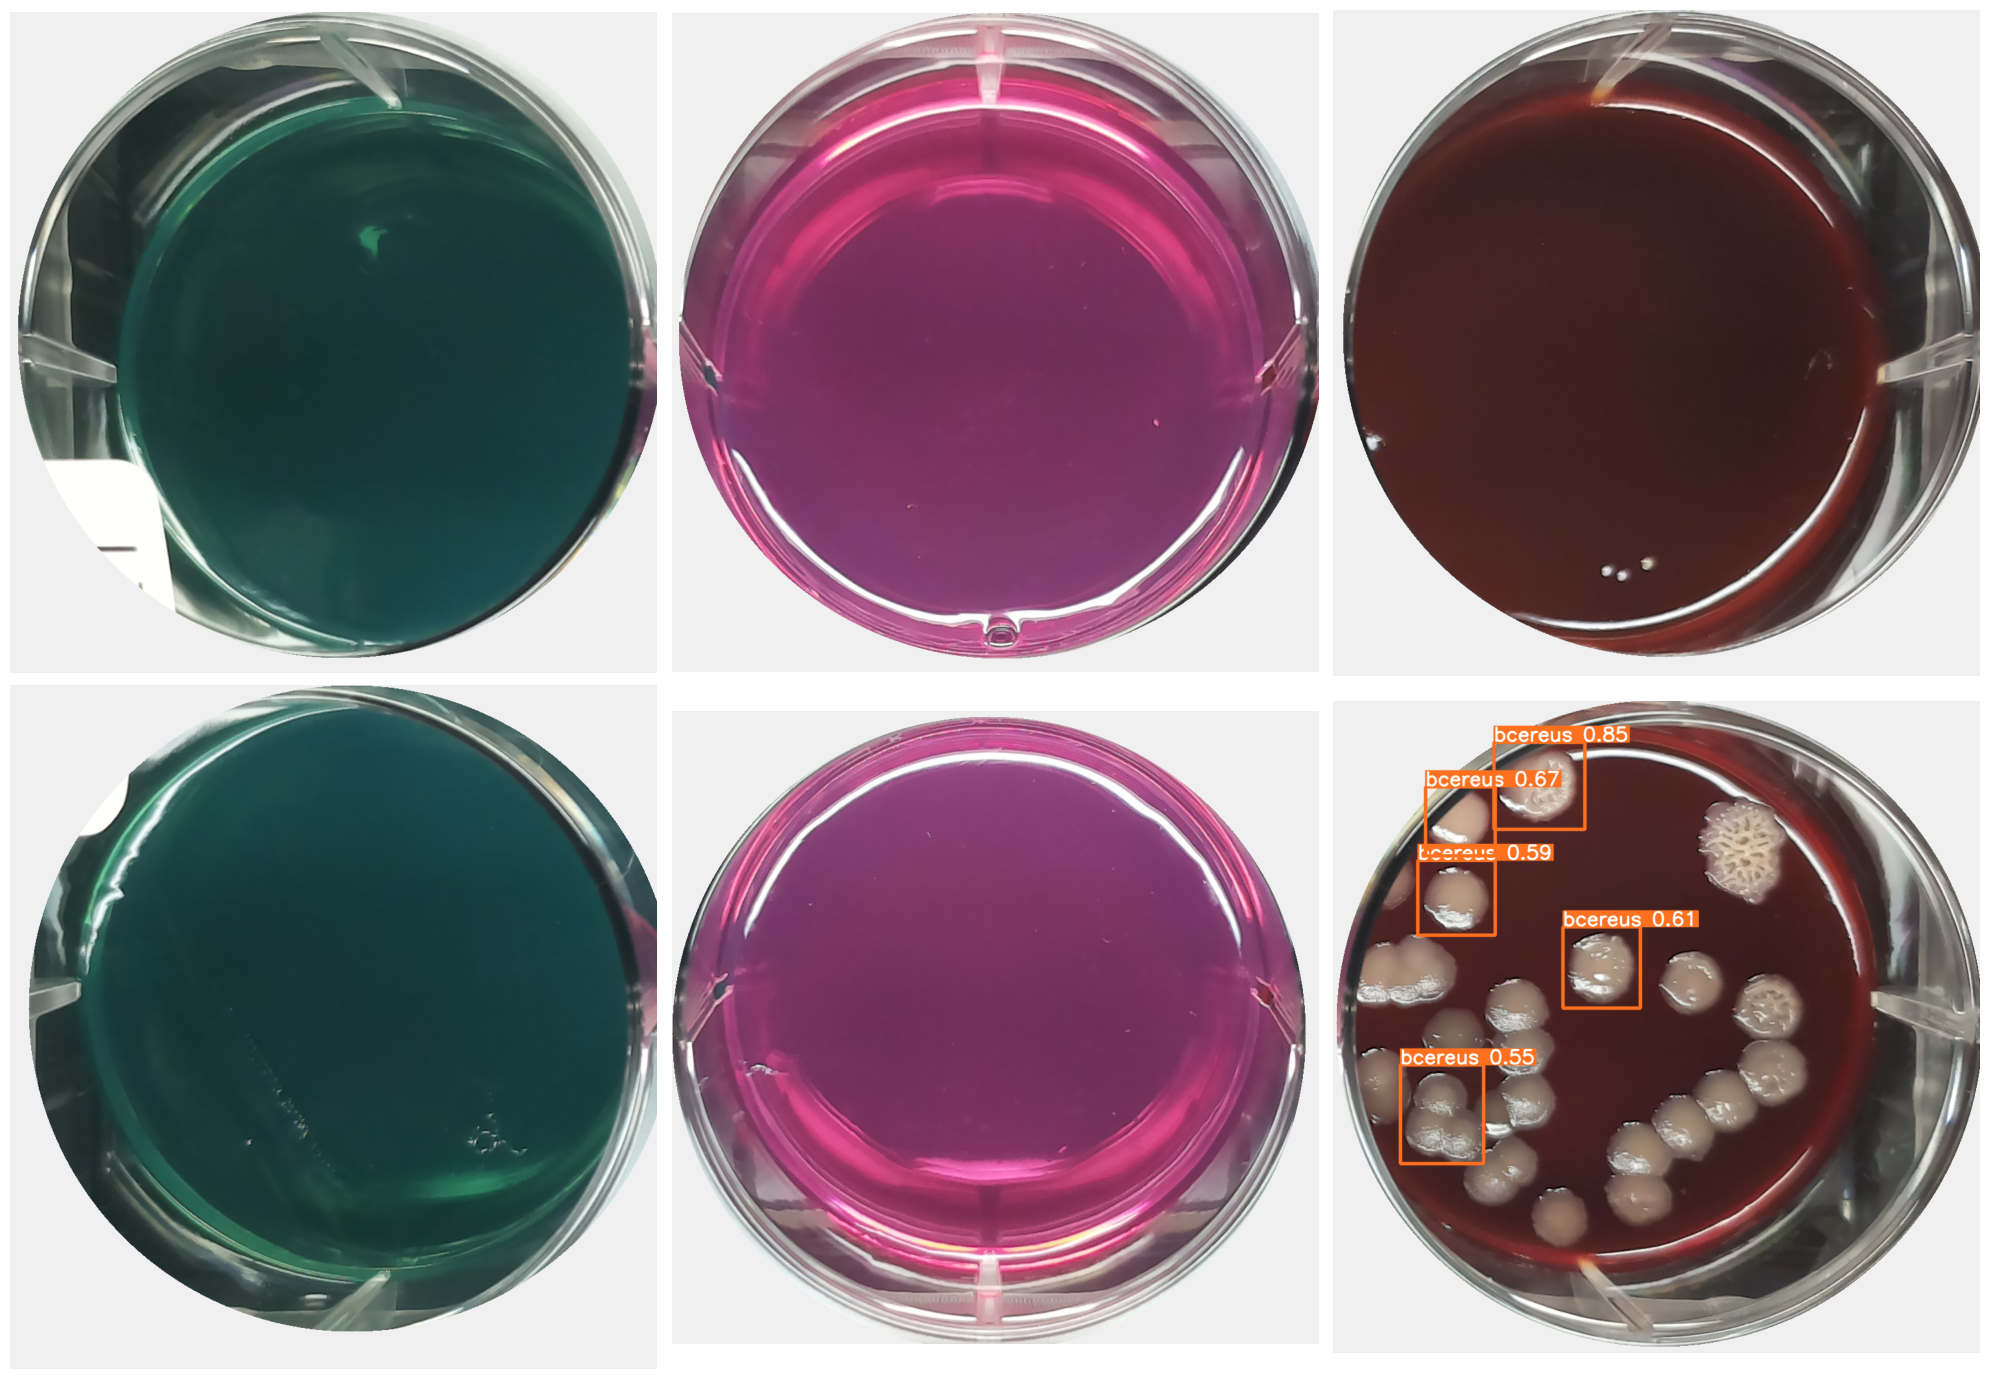

In [12]:
for experiment_folder_path in experiment_folders_paths:

    # Create 'outputs' folder
    folder_name = os.path.join(experiment_folder_path, 'outputs')
    
    if not os.path.exists(folder_name):
    # Create the folder
        os.makedirs(folder_name)

        images_paths = sorted([os.path.join(experiment_folder_path, path) for path in os.listdir(experiment_folder_path) if path.endswith('.jpg')])

        if len(images_paths)>0:
            # Read image (the latest for now)
            input_image = Image.open(images_paths[-1])

            # Get plate_id from the picture!
            plate_id = get_plateid_from_image(input_image, expected_digits=4)

            # Get row_sample_names
            row_sample_names = get_row_sample_info(plate_id, muestras_df, experiment_folder_path)

            # Get dictionary of the six agar predictions
            six_agar_predictions, pred_images = get_six_agar_predictions(input_image)

            # Merge into a prediction for each row
            upperRowPred, lowerRowPred = three_agars_to_one_prediction(six_agar_predictions["upperRowTCBS"], six_agar_predictions["upperRowMSA"], six_agar_predictions["upperRowBA"]), three_agars_to_one_prediction(six_agar_predictions["lowerRowTCBS"], six_agar_predictions["lowerRowMSA"], six_agar_predictions["lowerRowBA"])
            
            # Transform these predictions from species-level to family-level
            upperRowFamiliesPred, lowerRowFamiliesPred = species2families(upperRowPred), species2families(lowerRowPred)
            
            # Display as icons representing categories
            upperRowFamiliesIconsPred, lowerRowFamiliesIconsPred = families2icons(upperRowFamiliesPred), families2icons(lowerRowFamiliesPred)

            # Get results_df
            results_df = get_results_df(upperRowFamiliesPred, lowerRowFamiliesPred, row_sample_names).drop(columns="FechaPreparacion")
            
            if not os.path.exists(os.path.join(experiment_folder_path, 'outputs', 'results.xlsx')):
                results_df.to_excel(os.path.join(experiment_folder_path, 'outputs', 'results.xlsx'), index=False)
            if not os.path.exists(os.path.join(experiment_folder_path, 'outputs', 'yolo_predictions.jpg')):
                get_and_save_collage(pred_images, os.path.join(experiment_folder_path, 'outputs', 'yolo_predictions.jpg'))